<a target="_blank" href="https://colab.research.google.com/github/ashkan-mokarian/d2l-pytorch/blob/main/chapter_linear_NN_regression/1_linear_regression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Basics

In [1]:
!pip install d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.8 MB/s eta 0:00:00


In [11]:
import random
import time
import torch
import numpy as np
from d2l import torch as d2l

## Vectorization

In [6]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

c = torch.zeros(n)
ts = time.time()
# with for-loop
for i in range(n):
    c[i] = a[i] + b[i]
te = time.time()
print(f'For-loop took: {te-ts:.5f} ms')

c = torch.zeros(n)
ts = time.time()
# Vectorized
c = a + b
te = time.time()
print(f'Vectorization took: {te-ts:.5f} ms')

For-loop took: 0.12216 ms
Vectorization took: 0.00016 ms


## Decorating and OOP in notebook

In [9]:
class A:
    def __init__(self):
        self.b = 1
a = A()
a.do()

AttributeError: ignored

In [8]:
# Just adding in another cell
def do(self):
    print('Class attribute "b" is:', self.b)
setattr(A, do.__name__, do)
a.do()

Class attribute "b" is: 1


In [10]:
# or with decoration
def add_to_class(Class):
    """Register functions as method in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

@add_to_class(A)
def do(self):
    print('Class attribute "b" is:', self.b)
a.do()

Class attribute "b" is: 1


Some functionalities of the d2l package

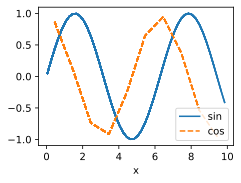

In [12]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

# Synthetic Regression Data

In [13]:
class SyntheticRegressionData(d2l.DataModule):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
print('features:', data.X[0], '\ntargets:', data.y[0])

features: tensor([-1.0410, -0.5665]) 
targets: tensor([4.0421])


In [16]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        yield self.X[i:i+self.batch_size], self.y[i:i+self.batch_size]

X, y = next(iter(data.get_dataloader(train=True)))
print('features:', X.shape, '\ntarget:', y.shape)

features: torch.Size([32, 2]) 
target: torch.Size([32, 1])


## Concise implementation in torch.utils.data.

In [27]:
@d2l.add_to_class(SyntheticRegressionData)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                       shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    dataset_indices = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, dataset_indices)

X, y = next(iter(data.get_dataloader(train=True)))
print('X shape:', X.shape, '\ny shape:', y.shape)
print(len(data.get_dataloader(train=True)))
print(len(data.get_dataloader(train=False)))

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
32
32


# Linear Regression implementatio from scratch

## Defining the Model

In [40]:
class LinearRegressionScratch(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [41]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

Defining the Loss

In [42]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

## Defining the Optimization Algorithm

In [51]:
class SGDScratch(d2l.HyperParameters):
    """Minibatch Stochastic Gradient Descent"""
    def __init__(self, params, lr):
        self.save_hyperparameters()
    
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

# Also add the optimizer configuration to the model
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    """Instanciate an SGD opimizer"""
    return SGDScratch([self.w, self.b], lr=self.lr)

## Training
Now that we have:
- parameters
- model
- loss
- optimizer
we can start training

In [46]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

putting all together

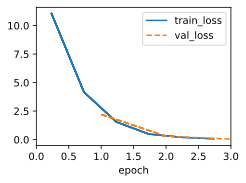

In [52]:
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [58]:
print(f'estimated parameters w:{model.w.detach()}; b:{model.b.detach()}')
print('error in estimating w: ', data.w - model.w.reshape(data.w.shape))
print('error in estimating b: ', data.b - model.b)

estimated parameters w:tensor([[ 1.9004],
        [-3.2206]]); b:tensor([4.0040])
error in estimating w:  tensor([ 0.0996, -0.1794], grad_fn=<SubBackward0>)
error in estimating b:  tensor([0.1960], grad_fn=<RsubBackward1>)


# Concise implementation of LinearRegression in PyTorch

In [59]:
class LinearRegression(d2l.Module):
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.LazyLinear(1)  # Lazy does not need input number as long as it can infer
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)
    
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y):
        fn = torch.nn.MSELoss()
        return fn(y_hat, y)
    
    def configure_optimizer(self):
        return torch.optim.SGD(params=self.net.parameters(), lr=self.lr)

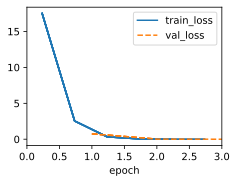

In [60]:
model = LinearRegression(lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2.0, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [61]:
@d2l.add_to_class(LinearRegression)
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'estimated parameters w:{w}; b:{b}')
print('error in estimating w: ', data.w - w.reshape(data.w.shape))
print('error in estimating b: ', data.b - b)

estimated parameters w:tensor([[ 1.9935, -3.3921]]); b:tensor([4.1884])
error in estimating w:  tensor([ 0.0065, -0.0079])
error in estimating b:  tensor([0.0116])


# Weight Decay for Regularization
Rather than directly manipulating the number of parameters to change model complexity, **weight decay** operates by restricting the values that parameters can take. It somehow limits the complexity of the model. The technique is motivated by the simple intuition that, among all functions $f$, the function $f=0$ is in some sense the _simplest_, and that we can measure the complexity of a function by the distance of its parameters to zero. But how to measure the distance precisely to zero? This is a hard question in functional analysis (Banach spaces, etc) and has no unique answer. Weight decay addresses this in the simplest form, i.e. $||w||$ some norm of the weights, simply added to the overall loss with a _regularization constant_ $λ$.

In [94]:
# Data chosen with high-dimensionality and low size to pronounce overfitting
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise
    
    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)

In [95]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [96]:
# same class as before but loss changes
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()
    
    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) + self.lambd * l2_penalty(self.w))

In [97]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale = 'log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.010696480050683022


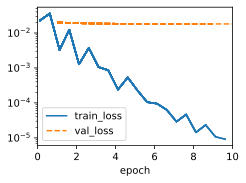

In [98]:
# without weight decay regularization
train_scratch(0)

L2 norm of w: 0.0016065973322838545


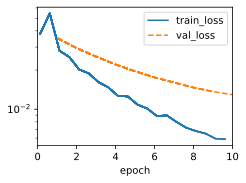

In [99]:
train_scratch(3)

## Concise implementation

In [102]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.014187315478920937


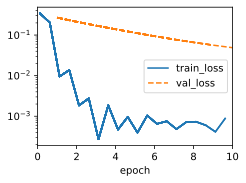

In [105]:
model = WeightDecay(3, 0.01)
model.board.yscale = 'log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))